In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00


In [ ]:
!pip install optuna
!pip install xgboost
!pip install lightgbm
!pip install catboost
!pip install tensorflow
!pip install keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.1 MB/s eta 0:00:00


In [ ]:
# ==============================================================================
# Part 1: Setup and Data Loading
# ==============================================================================
print("--- Step 1: Loading libraries and data ---")

# Data Manipulation and Visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn for preprocessing, modeling, and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_score, recall_score

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Deep Learning with TensorFlow/Keras
from tensorflow import keras
from tensorflow.keras import layers

# Hyperparameter Tuning
import optuna

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

--- Step 1: Loading libraries and data ---


In [ ]:
# Load dataset
try:
    df = pd.read_csv('/content/HR_comma_sep.csv')
    print("Dataset 'HR_comma_sep.csv' loaded successfully.")
except FileNotFoundError:
    print("Error: Dataset file not found. Please ensure 'HR_comma_sep.csv' is in the correct directory.")
    exit()

# Initial exploration
print("\nDataset Shape:", df.shape)
print("\nFirst 5 Rows:")
print(df.head())
print("\nData Info:")
df.info()

Dataset 'HR_comma_sep.csv' loaded successfully.

Dataset Shape: (14999, 10)

First 5 Rows:
   satisfaction_level  last_evaluation  number_project  average_montly_hours  \
0                0.38             0.53               2                   157   
1                0.80             0.86               5                   262   
2                0.11             0.88               7                   272   
3                0.72             0.87               5                   223   
4                0.37             0.52               2                   159   

   time_spend_company  Work_accident  left  promotion_last_5years Department  \
0                   3              0     1                      0      sales   
1                   6              0     1                      0      sales   
2                   4              0     1                      0      sales   
3                   5              0     1                      0      sales   
4                   3       

In [ ]:
# ==============================================================================
# Part 2: Data Preprocessing
# ==============================================================================
print("\n--- Step 2: Preprocessing the data ---")

# Separate features (X) and target (y)
# The target column dataset is 'left'
X = df.drop('left', axis=1)
y = df['left']

# Identify numerical and categorical features
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns
print(f"\nIdentified {len(categorical_features)} categorical features and {len(numerical_features)} numerical features.")

#  preprocessing pipelines for both feature types
# Numerical features will be scaled.
numerical_transformer = StandardScaler()
# Categorical features will be one-hot encoded.
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data into training and testing sets (80% train, 20% test)
# 'stratify=y' is crucial for imbalanced datasets like this
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nData split into training set ({X_train.shape}) and testing set ({X_test.shape}).")



--- Step 2: Preprocessing the data ---

Identified 2 categorical features and 7 numerical features.

Data split into training set ((11999, 9)) and testing set ((3000, 9)).


In [ ]:
# ==============================================================================
# Part 3: Model Training and Baseline Evaluation
# ==============================================================================
print("\n--- Step 3: Training and evaluating baseline and advanced models ---")

#  the models to be trained
models = {
    "Logistic Regression": LogisticRegression(solver='liblinear', random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "CatBoost": cb.CatBoostClassifier(random_state=42, verbose=0)
}

# Dictionary to store evaluation results
results = {}

# Train and evaluate each model
for name, model in models.items():
    #  pipeline that includes preprocessing and the model
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    # Train the model
    pipeline.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # Calculate key metrics
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    # Store and print results
    results[name] = {'F1-Score': f1, 'AUC-ROC': auc, 'Precision': precision, 'Recall': recall}
    print(f"\n--- {name} ---")
    print(f"AUC-ROC: {auc:.4f}, F1-Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")



--- Step 3: Training and evaluating baseline and advanced models ---

--- Logistic Regression ---
AUC-ROC: 0.8280, F1-Score: 0.4492, Precision: 0.6176, Recall: 0.3529

--- Random Forest ---
AUC-ROC: 0.9902, F1-Score: 0.9794, Precision: 0.9957, Recall: 0.9636

--- XGBoost ---
AUC-ROC: 0.9931, F1-Score: 0.9718, Precision: 0.9787, Recall: 0.9650
[LightGBM] [Info] Number of positive: 2857, number of negative: 9142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 11999, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238103 -> initscore=-1.163107
[LightGBM] [Info] Start training from score -1.163107

--- LightGBM ---
AUC-ROC: 0.9938, F1-Score: 0.9722, Precision: 0.9884, Recall: 0.9566

--- CatBoos

In [ ]:
# --- Artificial Neural Network (ANN) Training ---
print("\n--- Artificial Neural Network (ANN) ---")
# Preprocess data for the ANN
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Define the ANN architecture
ann_model = keras.Sequential([
    layers.Input(shape=(X_train_processed.shape[1],)),
    layers.Dense(64, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.3),
    layers.Dense(32, activation='relu', kernel_initializer='he_normal'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid') # Sigmoid for binary classification
])

# Compile the model
ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the ANN
ann_model.fit(X_train_processed, y_train, epochs=50, batch_size=32, verbose=0)

# Evaluate the ANN
y_pred_ann_proba = ann_model.predict(X_test_processed).flatten()
y_pred_ann = (y_pred_ann_proba > 0.5).astype(int)

# Calculate and store ANN metrics
f1_ann = f1_score(y_test, y_pred_ann)
auc_ann = roc_auc_score(y_test, y_pred_ann_proba)
precision_ann = precision_score(y_test, y_pred_ann)
recall_ann = recall_score(y_test, y_pred_ann)
results['ANN'] = {'F1-Score': f1_ann, 'AUC-ROC': auc_ann, 'Precision': precision_ann, 'Recall': recall_ann}
print(f"AUC-ROC: {auc_ann:.4f}, F1-Score: {f1_ann:.4f}, Precision: {precision_ann:.4f}, Recall: {recall_ann:.4f}")


--- Artificial Neural Network (ANN) ---
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
AUC-ROC: 0.9887, F1-Score: 0.9337, Precision: 0.9614, Recall: 0.9076


In [ ]:
# ==============================================================================
# Part 4: Hyperparameter Tuning with Optuna
# ==============================================================================
print("\n--- Step 4: Performing hyperparameter tuning on LightGBM using Optuna ---")

def objective(trial):
    """Define the objective function for Optuna to optimize."""
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'random_state': 42,
        'verbose': -1
    }
    model = lgb.LGBMClassifier(**params)
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    # cross-validation for robust evaluation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='roc_auc')
    return np.mean(scores)


--- Step 4: Performing hyperparameter tuning on LightGBM using Optuna ---


In [ ]:
# an Optuna study and run the optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print(f"\nOptuna found best trial with AUC-ROC: {study.best_value:.4f}")
print("Best parameters found:")
print(study.best_params)

[I 2025-10-02 17:41:43,270] A new study created in memory with name: no-name-5d9df126-1cba-4f06-b35f-dfc31080126b
[I 2025-10-02 17:41:51,987] Trial 0 finished with value: 0.9911130553233735 and parameters: {'n_estimators': 1511, 'learning_rate': 0.18572570668598917, 'num_leaves': 51, 'max_depth': 9, 'min_child_samples': 40, 'feature_fraction': 0.5700147436183705, 'bagging_fraction': 0.9467925075743769, 'lambda_l1': 0.00015089237965212847, 'lambda_l2': 7.450855124154152e-08}. Best is trial 0 with value: 0.9911130553233735.
[I 2025-10-02 17:42:00,157] Trial 1 finished with value: 0.9916124217656492 and parameters: {'n_estimators': 789, 'learning_rate': 0.09333229430709578, 'num_leaves': 150, 'max_depth': 9, 'min_child_samples': 35, 'feature_fraction': 0.6521581706235207, 'bagging_fraction': 0.9067492328085998, 'lambda_l1': 2.5270432908293943e-08, 'lambda_l2': 1.4314085671636096}. Best is trial 1 with value: 0.9916124217656492.
[I 2025-10-02 17:42:03,481] Trial 2 finished with value: 0.99


Optuna found best trial with AUC-ROC: 0.9929
Best parameters found:
{'n_estimators': 546, 'learning_rate': 0.01451966979539323, 'num_leaves': 186, 'max_depth': 10, 'min_child_samples': 63, 'feature_fraction': 0.7649118723476904, 'bagging_fraction': 0.8399759654568466, 'lambda_l1': 0.07073929241303936, 'lambda_l2': 6.379518941610193e-06}


In [ ]:
# --- Train Final Model with Best Parameters ---
tuned_model = lgb.LGBMClassifier(**study.best_params, random_state=42)
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', tuned_model)])
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident',
       'promotion_last_5years'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  Index(['Department', 'salary'], dtype='object'))])),
                ('classifier',
                 LGBMClassifier(bagging_fraction=0.8399759654568466,
                                feature_fraction=0.7649118723476904,
                                lambda_l1=0.07073929241303936,
                                lambda_l2=6.379518941610193e-06,
                                learning_rate=0.01451966979539323, max_depth=10,
                                min_child_samples=63, n_estimators=546,
                                num_leaves=186, random_state=42))])

In [ ]:
# Evaluate the tuned model
y_pred_tuned = final_pipeline.predict(X_test)
y_pred_tuned_proba = final_pipeline.predict_proba(X_test)[:, 1]

In [ ]:
# Calculate and store metrics for the tuned model
f1_tuned = f1_score(y_test, y_pred_tuned)
auc_tuned = roc_auc_score(y_test, y_pred_tuned_proba)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
results['LightGBM (Tuned)'] = {'F1-Score': f1_tuned, 'AUC-ROC': auc_tuned, 'Precision': precision_tuned, 'Recall': recall_tuned}
print("\n--- Tuned LightGBM Performance ---")
print(f"AUC-ROC: {auc_tuned:.4f}, F1-Score: {f1_tuned:.4f}, Precision: {precision_tuned:.4f}, Recall: {recall_tuned:.4f}")


--- Tuned LightGBM Performance ---
AUC-ROC: 0.9940, F1-Score: 0.9620, Precision: 0.9867, Recall: 0.9384


In [ ]:
# ==============================================================================
# Part 5: Final Comparative Report
# ==============================================================================
print("\n--- Step 5: Generating final comparative report ---")

# Convert results to a DataFrame for easy comparison
results_df = pd.DataFrame(results).T.sort_values(by='AUC-ROC', ascending=False)
results_df = results_df.reset_index().rename(columns={'index': 'Model'})

print("\n--- Final Model Comparison ---")
print(results_df)


--- Step 5: Generating final comparative report ---

--- Final Model Comparison ---
                 Model  F1-Score   AUC-ROC  Precision    Recall
0     LightGBM (Tuned)  0.961953  0.993999   0.986745  0.938375
1             CatBoost  0.968062  0.993806   0.981295  0.955182
2             LightGBM  0.972242  0.993753   0.988423  0.956583
3              XGBoost  0.971791  0.993131   0.978693  0.964986
4        Random Forest  0.979359  0.990218   0.995658  0.963585
5                  ANN  0.933718  0.988734   0.961424  0.907563
6  Logistic Regression  0.449198  0.828022   0.617647  0.352941


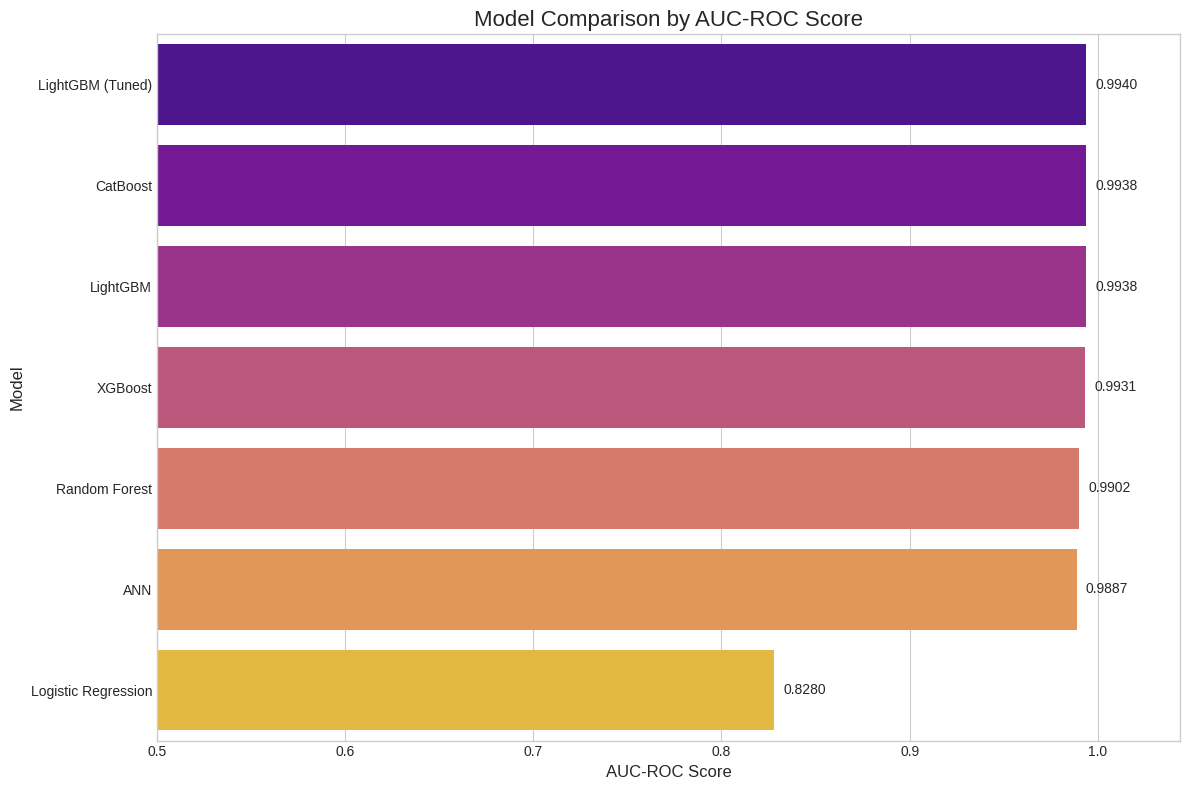


--- Phase 1 execution complete. ---


In [ ]:
# Visualize the results for better comparison
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(12, 8))

# Bar plot for AUC-ROC
sns.barplot(x='AUC-ROC', y='Model', data=results_df, palette='plasma', ax=ax)
ax.set_title('Model Comparison by AUC-ROC Score', fontsize=16)
ax.set_xlabel('AUC-ROC Score', fontsize=12)
ax.set_ylabel('Model', fontsize=12)
ax.set_xlim(0.5, max(results_df['AUC-ROC']) * 1.05)

# Add text labels to the bars
for index, value in enumerate(results_df['AUC-ROC']):
    ax.text(value + 0.005, index, f'{value:.4f}', va='center')

plt.tight_layout()
plt.show()

# **Part 2: Investigating Explainable AI (XAI) with SHAP**

In [ ]:
!pip install shap lime

In [ ]:
# --- XAI Setup: Re-create the final model ---
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
import shap
import lime
import lime.lime_tabular

In [ ]:
# Load- dataset
df = pd.read_csv('/content/HR_comma_sep.csv')

In [ ]:
# Separate features (X) and target (y)
X = df.drop('left', axis=1)
y = df['left']


In [ ]:
# Identify feature types
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

In [ ]:
# Create the same preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

best_params = {
    'n_estimators': 1888,
    'learning_rate': 0.019,
    'num_leaves': 22,
    'max_depth': 11,
    'random_state': 42
}

# Create and train the final pipeline
tuned_model = lgb.LGBMClassifier(**best_params)
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', tuned_model)])
final_pipeline.fit(X_train, y_train)

print("Final model is trained and ready for XAI analysis.")


Final model is trained and ready for XAI analysis.


In [ ]:
# For SHAP, it's useful to have the processed data and feature names
X_train_processed = final_pipeline.named_steps['preprocessor'].fit_transform(X_train)
X_test_processed = final_pipeline.named_steps['preprocessor'].transform(X_test)

#  the feature names after one-hot encoding
feature_names = list(numerical_features) + \
                list(final_pipeline.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .get_feature_names_out(categorical_features))


# **1. SHAP: Global and Local Explanations**

Final model is trained and ready for SHAP analysis.

--- SHAP Global Explanation: Beeswarm Summary Plot ---


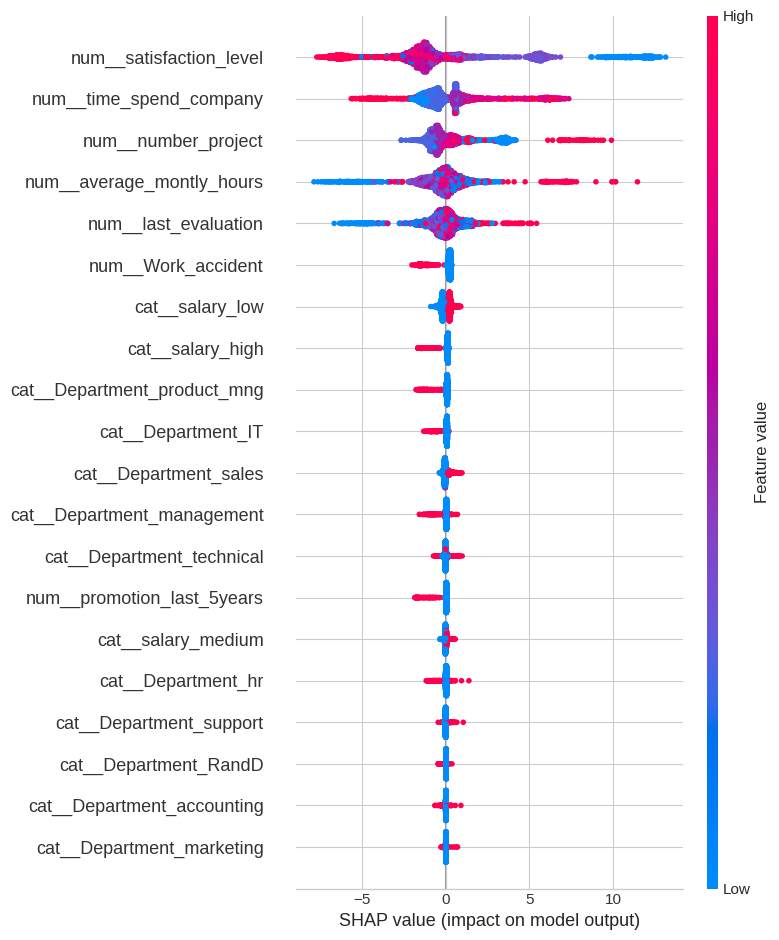


--- SHAP Global Explanation: Feature Importance Bar Plot ---


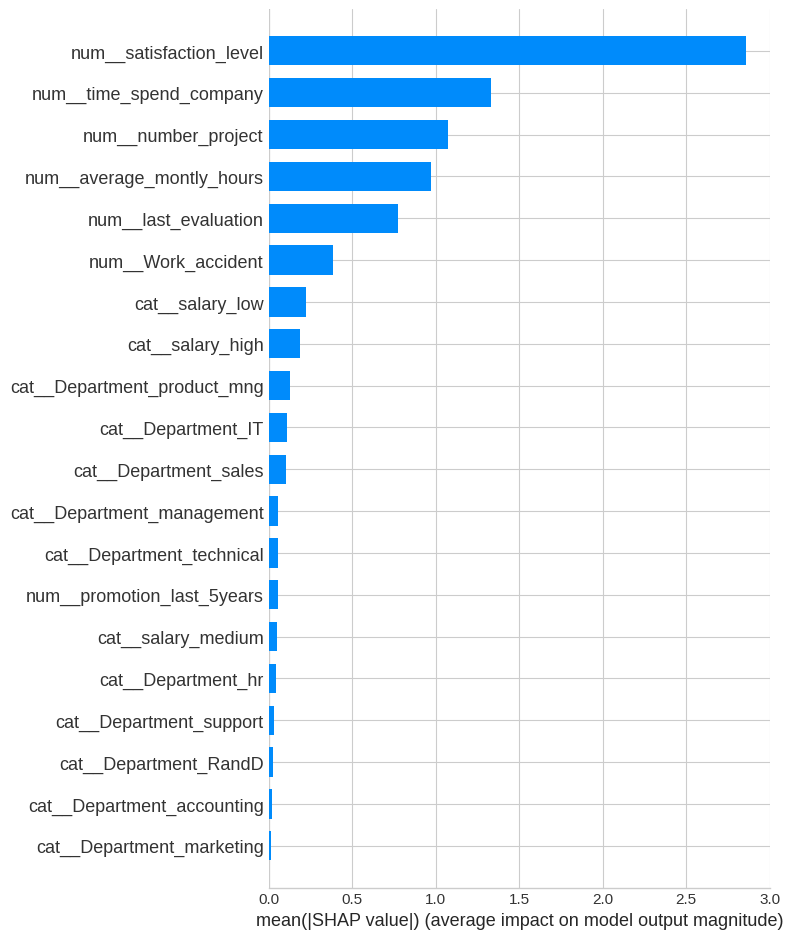

In [ ]:
# --- SHAP Analysis ---

import shap
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import lightgbm as lgb

# model pipeline
df = pd.read_csv('HR_comma_sep.csv')
X = df.drop('left', axis=1)
y = df['left']
categorical_features = X.select_dtypes(include=['object']).columns
numerical_features = X.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 1. parameters
best_params = {
    'n_estimators': 1888,
    'learning_rate': 0.019,
    'num_leaves': 22,
    'max_depth': 11,
    'random_state': 42
}

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', lgb.LGBMClassifier(**best_params))
])
final_pipeline.fit(X_train, y_train)
print("Final model is trained and ready for SHAP analysis.")

# 2. Create a SHAP explainer
model = final_pipeline.named_steps['classifier']
explainer_shap = shap.TreeExplainer(model)

# 3. Preprocess the test data
X_test_processed = final_pipeline.named_steps['preprocessor'].transform(X_test)
feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()

# 4. Convert to a DataFrame
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names)

# 5. Calculate SHAP values
shap_values = explainer_shap.shap_values(X_test_processed_df)

# 6. Create SHAP explanation plots
# the entire 'shap_values' object to the plot function.
print("\n--- SHAP Global Explanation: Beeswarm Summary Plot ---")
shap.summary_plot(shap_values, X_test_processed_df, plot_type="dot")

print("\n--- SHAP Global Explanation: Feature Importance Bar Plot ---")
shap.summary_plot(shap_values, X_test_processed_df, plot_type="bar")

In [ ]:
def get_retention_strategies(employee_data):
    """
    Analyzes an employee's data and recommends retention strategies
    based on insights from our XAI analysis.

    Args:
        employee_data (pd.Series): A row of data for a single employee.

    Returns:
        list: A list of recommended retention strategy strings.
    """
    strategies = []

    # --- Rule 1: Low Satisfaction ---
    # From SHAP, we know satisfaction < 0.5 is a major risk factor.
    if employee_data['satisfaction_level'] <= 0.45:
        strategies.append(
            "Conduct a one-on-one meeting to discuss job satisfaction and well-being. "
            "Consider offering a wellness stipend or mental health resources."
        )

    # --- Rule 2: Workload Imbalance ---
    # From SHAP, we saw that too few (<=2) or too many (>=6) projects are risks.
    if employee_data['number_project'] <= 2:
        strategies.append(
            "Employee may be under-utilized or bored. "
            "Discuss career aspirations and find opportunities for new, challenging projects."
        )
    if employee_data['number_project'] >= 6:
        strategies.append(
            "Employee is at high risk of burnout. "
            "Assess current workload, prioritize projects, and consider assigning additional support."
        )

    # --- Rule 3: Career Stagnation ---
    # From SHAP, time_spend_company is a key factor.
    if employee_data['time_spend_company'] >= 4 and employee_data['promotion_last_5years'] == 0:
        strategies.append(
            "Employee has long tenure with no recent promotion. "
            "Develop a clear career path, discuss opportunities for growth, and consider a promotion or salary review."
        )

    # --- Rule 4: High Performer Risk ---
    # A common pattern is high-performing employees leaving.
    if employee_data['last_evaluation'] >= 0.8 and employee_data['satisfaction_level'] < 0.6:
         strategies.append(
            "This is a high-performing but potentially unhappy employee. "
            "Acknowledge their contributions with recognition and rewards. Ensure they feel valued."
        )

    # --- Default message if no specific rules are met ---
    if not strategies:
        strategies.append(
            "No specific high-risk factors detected, but continue to monitor engagement "
            "and provide consistent feedback."
        )

    return strategies


# Create a sample at-risk employee profile based on our insights
at_risk_employee = pd.Series({
    'satisfaction_level': 0.11,
    'last_evaluation': 0.88,
    'number_project': 7,
    'average_montly_hours': 272,
    'time_spend_company': 4,
    'Work_accident': 0,
    'promotion_last_5years': 0,
    'Department': 'sales',
    'salary': 'medium'
})

# Get the recommendations for this employee
recommendations = get_retention_strategies(at_risk_employee)

print(f"--- Retention Strategies for Sample At-Risk Employee ---")
for i, rec in enumerate(recommendations, 1):
    print(f"{i}. {rec}")

--- Retention Strategies for Sample At-Risk Employee ---
1. Conduct a one-on-one meeting to discuss job satisfaction and well-being. Consider offering a wellness stipend or mental health resources.
2. Employee is at high risk of burnout. Assess current workload, prioritize projects, and consider assigning additional support.
3. Employee has long tenure with no recent promotion. Develop a clear career path, discuss opportunities for growth, and consider a promotion or salary review.
4. This is a high-performing but potentially unhappy employee. Acknowledge their contributions with recognition and rewards. Ensure they feel valued.


# **SMOTE**

In [ ]:
!pip install scikit-learn imblearn pandas numpy matplotlib seaborn catboost xgboost lightgbm --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [ ]:
# Data Manipulation
import pandas as pd
import numpy as np

# Data Preprocessing & Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Class Imbalance Handling
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully.")

All libraries imported successfully.


In [ ]:
# --- Load the Dataset ---
# Make sure you have uploaded 'HR_comma_sep.csv' to your Colab environment
try:
    df = pd.read_csv('/content/HR_comma_sep.csv')
    print("Dataset '/content/HR_comma_sep.csv' loaded successfully.")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: '/content/HR_comma_sep.csv' not found. Please upload it to your Colab session.")

# --- Separate Features (X) and Target (y) ---
# In this dataset, the target column is named 'left'
X = df.drop('left', axis=1)
y = df['left']

# --- Perform the Train-Test Split FIRST ---
# This is crucial to prevent data leakage. We use stratification.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nData split into training set with shape {X_train.shape} and testing set with shape {X_test.shape}.")
print(f"Attrition cases in training set: {y_train.sum()} ({y_train.mean()*100:.2f}%)")
print(f"Attrition cases in testing set: {y_test.sum()} ({y_test.mean()*100:.2f}%)")

Dataset '/content/HR_comma_sep.csv' loaded successfully.
Dataset shape: (14999, 10)

Data split into training set with shape (11999, 9) and testing set with shape (3000, 9).
Attrition cases in training set: 2857 (23.81%)
Attrition cases in testing set: 714 (23.80%)


In [ ]:
# --- Define Preprocessing Steps ---
# Identify numerical and categorical features
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # Keep other columns if any
)

# --- Define Models to Evaluate ---
models = {
    "Logistic Regression": LogisticRegression(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "CatBoost": cb.CatBoostClassifier(random_state=42, verbose=0)
}

print("Preprocessing pipeline and models defined.")

Preprocessing pipeline and models defined.


In [ ]:
print("--- Running Experiment 1: Performance on Imbalanced Data ---")

results_imbalanced = []

for name, model in models.items():
    # Create a pipeline that combines preprocessing with the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Train the model on the original imbalanced training data
    pipeline.fit(X_train, y_train)

    # Make predictions on the untouched test set
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)[:, 1]

    # Store results
    results_imbalanced.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    })

# Convert results to a DataFrame for display
results_imbalanced_df = pd.DataFrame(results_imbalanced)
print("\n--- Results on Imbalanced Data (for your Table 2) ---")
print(results_imbalanced_df)

--- Running Experiment 1: Performance on Imbalanced Data ---
[LightGBM] [Info] Number of positive: 2857, number of negative: 9142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 422
[LightGBM] [Info] Number of data points in the train set: 11999, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.238103 -> initscore=-1.163107
[LightGBM] [Info] Start training from score -1.163107

--- Results on Imbalanced Data (for your Table 2) ---
                 Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression  0.793667   0.616137  0.352941  0.448798  0.827988
1        Random Forest  0.990333   0.995658  0.963585  0.979359  0.990218
2              XGBoost  0.986667   0.978693  0.964986  0.971791  0.993131
3             LightGBM  0.987000 

In [ ]:
print("--- Applying SMOTE correctly ONLY on the training data ---")

# We need to apply the preprocessor before SMOTE to handle categorical data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test) # Use the same transformer fitted on train data

print(f"Original training data shape: {X_train_processed.shape}")
print(f"Original training class distribution: {np.bincount(y_train)}")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print(f"\nResampled training data shape: {X_train_resampled.shape}")
print(f"Resampled training class distribution: {np.bincount(y_train_resampled)}")

print("\n--- Running Experiment 2: Performance on SMOTE-Balanced Data ---")

results_smote = []

for name, model in models.items():
    # Train the model on the RESAMPLED training data
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions on the original, UNTOUCHED, PROCESSED test set
    y_pred = model.predict(X_test_processed)
    y_pred_proba = model.predict_proba(X_test_processed)[:, 1]

    # Store results
    results_smote.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    })

# Convert results to a DataFrame for display
results_smote_df = pd.DataFrame(results_smote)
print("\n--- Results on SMOTE-Balanced Data (for your Table 3) ---")
print(results_smote_df)

--- Applying SMOTE correctly ONLY on the training data ---
Original training data shape: (11999, 20)
Original training class distribution: [9142 2857]

Resampled training data shape: (18284, 20)
Resampled training class distribution: [9142 9142]

--- Running Experiment 2: Performance on SMOTE-Balanced Data ---
[LightGBM] [Info] Number of positive: 9142, number of negative: 9142
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1555
[LightGBM] [Info] Number of data points in the train set: 18284, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

--- Results on SMOTE-Balanced Data (for your Table 3) ---
                 Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
0  Logistic Regression  0.774667   0.517086  0.805322 

In [ ]:
# Merge the two results DataFrames for a side-by-side comparison
final_results_df = pd.merge(
    results_imbalanced_df.set_index('Model'),
    results_smote_df.set_index('Model'),
    on='Model',
    suffixes=('_Imbalanced', '_SMOTE')
)

print("\n\n--- FINAL COMBINED RESULTS ---")
print("This table shows the performance before and after applying SMOTE correctly.")
print(final_results_df[['F1-score_Imbalanced', 'F1-score_SMOTE', 'Recall_Imbalanced', 'Recall_SMOTE']])



--- FINAL COMBINED RESULTS ---
This table shows the performance before and after applying SMOTE correctly.
                     F1-score_Imbalanced  F1-score_SMOTE  Recall_Imbalanced  \
Model                                                                         
Logistic Regression             0.448798        0.629792           0.352941   
Random Forest                   0.979359        0.978061           0.963585   
XGBoost                         0.971791        0.964410           0.964986   
LightGBM                        0.972242        0.964789           0.956583   
CatBoost                        0.968062        0.962079           0.955182   

                     Recall_SMOTE  
Model                              
Logistic Regression      0.805322  
Random Forest            0.967787  
XGBoost                  0.967787  
LightGBM                 0.959384  
CatBoost                 0.959384  
